In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')   # So we don't need to see the useless iteration output when fitting the model. 

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Futures Settle Prices'}, xlabel='Date', ylabel='Settle Price in $USD'>

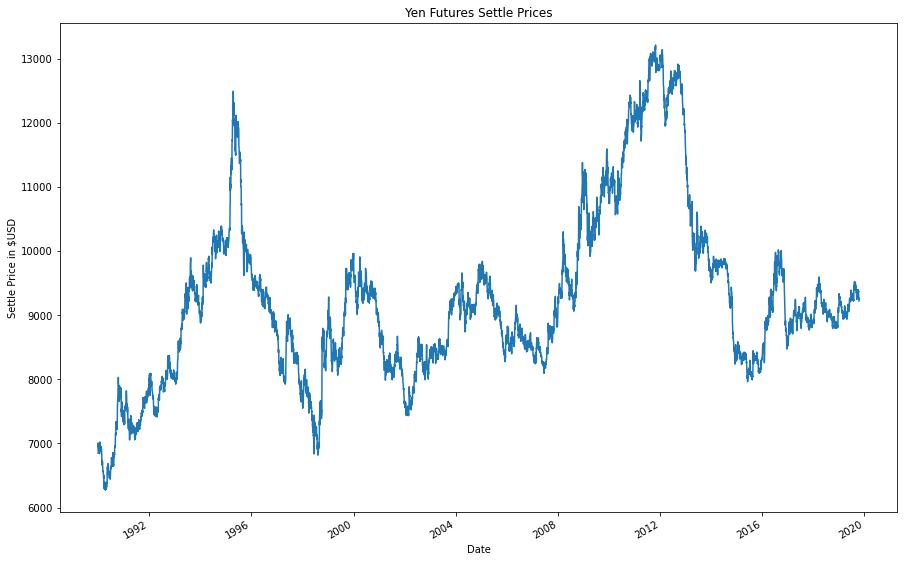

In [4]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
yen_futures['Settle'].plot(title='Yen Futures Settle Prices', ylabel='Settle Price in $USD', figsize=(15,10))

##### CODER'S NOTE:

Overall the view of the data looks non-stationary and that some kind of trend exists. I am seeing a pattern of gradual incrases followed by gradual decreases, in approximately 4-year intervals. From 1992-1996 there's increase from 6000-12,700, and the from 1996-2000 it gradually declines below 7000 by 1998-1999. There's intermittent bursts of micro-increases and decreases in the trends, likely seasonality is playing a role in that. Year-over-year along the x-axis, we see from approx years 2003-2013 there's a trending increase the spikes in data getting more pronounced. Lots of spikiness plotted raw data presented. 

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])    

# the Hodrick-Presscott filter takes out short-term fluctuations in the time-series. Separating into trend and non-trend components. 

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
decomposed_yen_settle_prices = pd.DataFrame(yen_futures['Settle'])
decomposed_yen_settle_prices['noise'] = settle_noise
decomposed_yen_settle_prices['trend'] = settle_trend
decomposed_yen_settle_prices.head()


,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle vs. Trend'}, xlabel='Date', ylabel='Settle Price in $USD'>

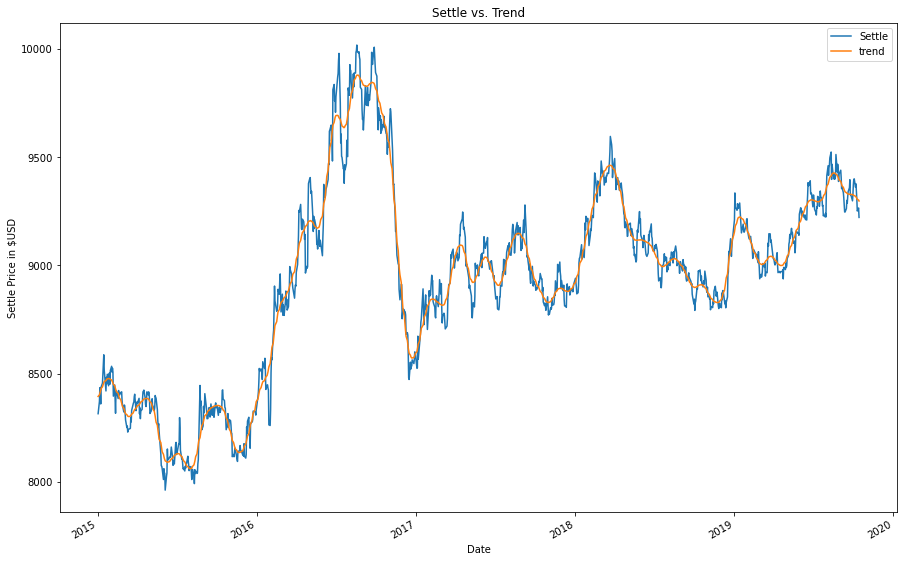

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
decomposed_yen_settle_prices[['Settle', 'trend']]['2015-01-01':].plot(title='Settle vs. Trend', ylabel='Settle Price in $USD', figsize=(15,10))

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

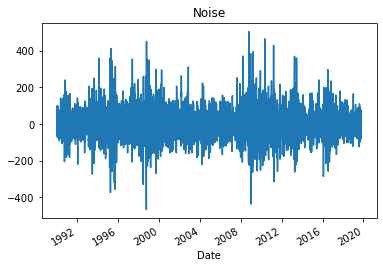

In [8]:
# Plot the Settle Noise
# YOUR CODE HERE!
decomposed_yen_settle_prices['noise'].plot(title='Noise')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)                    # run the pct_change() * 100 to transform non-stationary data to stationary for model.
returns = returns.replace(-np.inf, np.nan).dropna()                       # drop nulls after a pct_change() 
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [10]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model_1 = sm.tsa.ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results_1 = model_1.fit()

In [11]:
# Output model summary results:
# YOUR CODE HERE!
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 17 Mar 2022   AIC                          15798.142
Time:                        01:47:22   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3354           +0.0000j            3.3354            0.5000
AR.2         -157.2059           +0.0000j          157.2059            0.5000
MA.1           -3.3943           +0.0000j            3.3943            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Model 1 - ARMA: Predicted Yen Settle Price Returns 5-Day Forecast'}, ylabel='Settle Price in $USD'>

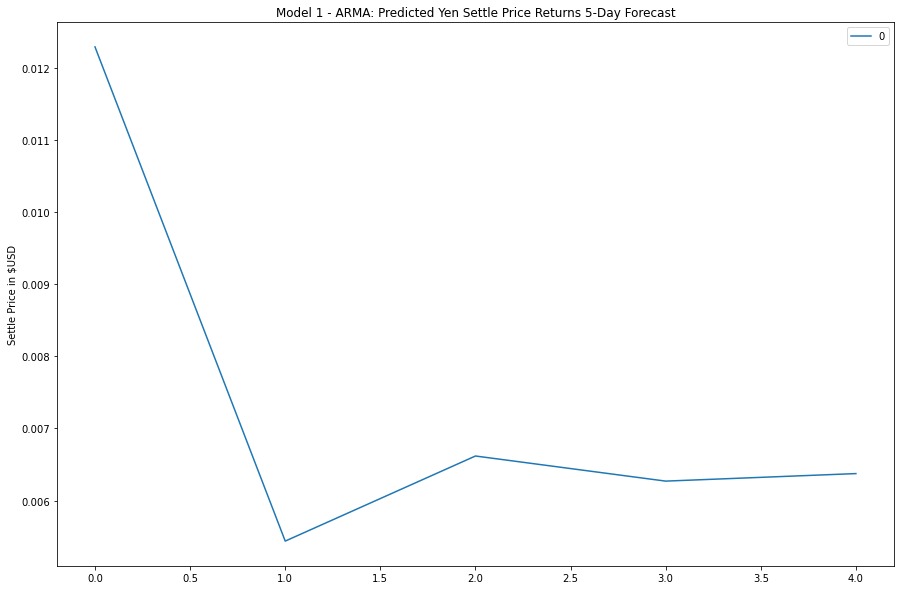

In [12]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
forecast_1 = pd.DataFrame(
    results_1.forecast(steps=5)[0]
)
forecast_1.plot(title='Model 1 - ARMA: Predicted Yen Settle Price Returns 5-Day Forecast', ylabel='Settle Price in $USD', figsize=(15,10))

##### CODER'S NOTE: Was this ARMA model a good fit based on the p-values in the model summary? NOPE. 

We cannot be confident in this model to predict dollar-return on Yen futures with this time-series. 

Looking at the ARMA model summary report of the results.
* The graph predicts based on the series, that USD returns on the Yen will deeply fall from .012 to less than .006 in the short-term, but then gradually recover increase up to .007 and stablize at approx above .0675? 
* This model is based on **7514** datapoints or *observations*.
* We are using a **second-order** ARMA model. Denoted with the order value 2 for the *Auto-Regressive* component, and value 1 for the *Moving-Average*. 
* We want the p-value to be **less than 0.5** to determine goodness of fit. The more closer to zero, the more confidence we have that the data is **stationary** as in, we can be confident the probability to reject the **null hypothesis** that the data isn't random (non-stationary) is high. And no **unit root** is acting on the series. 
* Most of the p-values are well above that 0.05 confidence limit. This would suggest the series in the model is not fully stationary for us to confidently predict Yen prices.
* The auto-regressive coefficient lag term-1, or **ar.L1.y**, is has an error range of **-2.81** to **2.18** which far outside the acceptable error limits of 0.025-0.975. This means our lag terms are not statistically relevant. The same goes for the moving average term **ma.L1.y**. 
* Both the AIC (Akaike Information Criterion) and the BIC (Bayesian Information Criterion) metrics should be strongly negative values, close in numeric value. But these are highly positive. 

Solutions:
* We can increase the model order, adding lag terms to lower the p-values. 
* Get more data in the series. 

In [13]:
# Adjusting the lag-terms of the ARMA model to see if p-values become lower. 

model_1_fixed = sm.tsa.ARMA(returns.values, order=(3,1))
results_1_fixed = model_1_fixed.fit()
results_1_fixed.summary()

# Adding another auto-regressive lag-term lowered the p-values for some of the lag-terms.
# Adding another moving average lag-term resulted in all the p-values for all our lag-terms to be completely zero??? 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(3, 1)   Log Likelihood               -7892.488
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 17 Mar 2022   AIC                          15796.977
Time:                        01:47:32   BIC                          15838.524
Sample:                             0   HQIC                         15811.243
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.837      0.403      -0.009       0.021
ar.L1.y        0.5431      0.235      2.310      0.021       0.082       1.004
ar.L2.y        0.0058      0.013      0.434      0.664      -0.020       0.032
ar.L3.y       -0.0169      0.012     -1.408      0.159      -0.040       0.007
ma.L1.y       -0.5550      0.235     -2.362      0.018      -1.015      -0.094
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0720           +0.0000j            2.0720            0.0000
AR.2            4.5493           +0.0000j            4.5493            0.0000
AR.3           -6.2766           +0.0000j            6.2766            0.5000
MA.1            1.8019           +0.0000j            1.8019            0.0000
-----------------------------------------------------------------------------
"""

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [14]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
model_2 = ARIMA(yen_futures['Settle'], order=(5, 1, 1))     # Here we are passing the original yen data from the Settle column. 

# Fit the model
# YOUR CODE HERE!
results_2 = model_2.fit()

C:\Users\jakel\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jakel\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [15]:
# Output model summary results:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 17 Mar 2022   AIC                          83905.238
Time:                        01:47:47   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2973      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8918           -1.3785j            2.3408           -0.1002
AR.2            1.8918           +1.3785j            2.3408            0.1002
AR.3           -2.2704           -3.0202j            3.7784           -0.3526
AR.4           -2.2704           +3.0202j            3.7784            0.3526
AR.5          -11.0827           -0.0000j           11.0827           -0.5000
MA.1            3.3638           +0.0000j            3.3638            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Model 2 - ARIMA: Predicted Yen Settle Price Returns 5-Day Forecast'}, ylabel='Settle Price in $USD'>

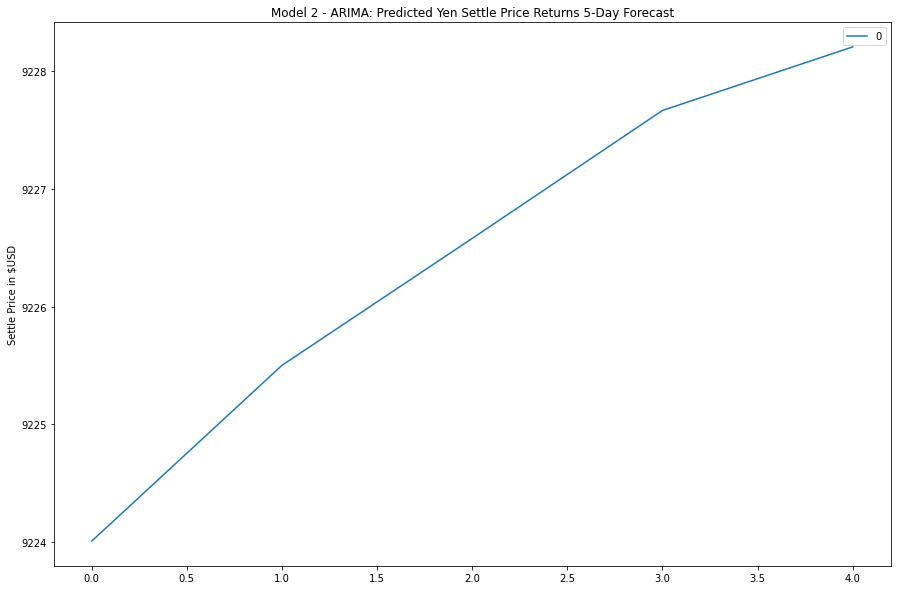

In [16]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
forecast_2 = pd.DataFrame(
    results_2.forecast(steps=5)[0]
)
forecast_2.plot(title='Model 2 - ARIMA: Predicted Yen Settle Price Returns 5-Day Forecast', ylabel='Settle Price in $USD', figsize=(15,10))

##### CODER'S NOTE: Was this ARIMA model a good fit based on the p-values in the model summary? NOPE. 

* There are more auto-regressive lag terms added into this model. But still we cannot be confident the model can predict Yen returns.
* The p-values are still high. Not even close the .05 or lower threshold we want. 
* The forcasted returns are showing continuous increases throughtout the next 5 days, whereas our the first model showed a sharp decline in performance with a small increase that tapers off. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [17]:
from arch import arch_model

In [18]:
returns

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275
...,...
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304


In [19]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model_3 = arch_model(returns['Settle'], mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model
# YOUR CODE HERE!
results_3 = model_3.fit(disp='off')

In [20]:
# Summarize the model results
# YOUR CODE HERE!
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Thu, Mar 17 2022   Df Residuals:                     7511
Time:                        01:48:07   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

In [21]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [22]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecast_3 = results_3.forecast(start=last_day, horizon=forecast_horizon)

In [23]:
# Annualize the forecast
intermediate = np.sqrt(forecast_3.variance.dropna() * 252)
intermediate.head()

# If forecast horizon is 5, then the resulting horizons 'h.1', 'h.2', 'h.4', and 'h.5'
# Over the next 5 horizons (days) we will expect returns ranging from 7.43 to 7.59. The returns gradually increase with each day. 

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434026,7.475721,7.516842,7.5574,7.597407


In [24]:
# Transpose the forecast so that it is easier to plot
forecast_3_final = intermediate.dropna().T
forecast_3_final.head()

Date,2019-10-15
h.1,7.434026
h.2,7.475721
h.3,7.516842
h.4,7.557400
h.5,7.597407


<AxesSubplot:title={'center':'Model 3 - GARCH: Predicted Yen Settle Price Volatility 5-Day Forecast'}, ylabel='Settle Price in $USD'>

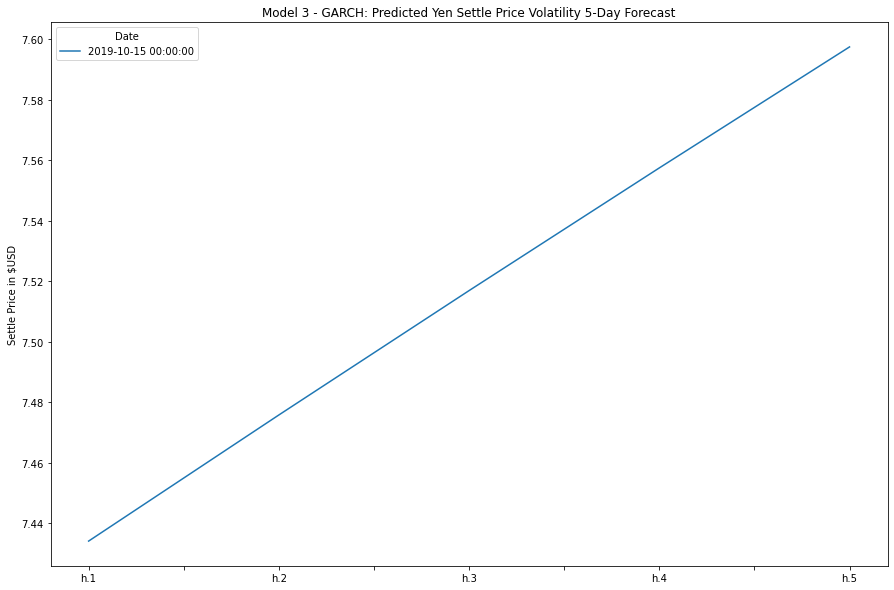

In [28]:
# Plot the final forecast
# YOUR CODE HERE!
forecast_3_final.plot(title='Model 3 - GARCH: Predicted Yen Settle Price Volatility 5-Day Forecast', ylabel='Settle Price in $USD', figsize=(15,10))

# We see along the a-xiis volatility keeps increasing over the next 5 days. Not good. This makes the decision to buy the Ywn

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

Yes. It would be practical to buy JPY now based on the results of these models ASSUMING we do not have more data to input into these models, and we can tolerate the increasing volatilty in Yen value. 

Both the ARMA and ARIMA models show the value of the Yen will increase in the next 5 days. That's not bad. However, given each model summary of results in regards to high p-values of these models, the probabiltuy of the model to predict value based on randomness is low. Higher p-values suggest something is acting on this data, and coupled with high volatility makes the decision murky. 

The GARCH model also shows that heteroskedacity in JPY price volatility increases along the x-axis over the next 5 days. Lots of volatiltiy involved in this trade. 